# Lesson 0037 - Yours truly Deep Dream
In this lesson, we will create a deep dreaming image.<br>
The idea of deep dreaming is, that one employs a network that is already trained to an image and adds a mask to the input image. This mask is modified in order to maximize the response of certain filters in the network.<br>
For this task, we employ the [Inception V3](https://keras.io/applications/#inceptionv3) model.

In [1]:
import keras
from keras.applications import inception_v3

print( keras.__version__ )

Using TensorFlow backend.


2.2.4


Next we import the [backend](https://keras.io/backend/) and set the [learning_phase](https://keras.io/backend/) to $0$ to ensure, that we do not change the weights in the inception model.

In [2]:
from keras import backend as b

b.set_learning_phase( 0 )

In [3]:
model = inception_v3.InceptionV3( weights = "imagenet", include_top = False )

Instructions for updating:
Colocations handled automatically by placer.


Now, let's have a look at the model.

In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

We could maximize the response of several filters, but we limit ourselves to the __mixed__ layers, because there, all the different computational pipelines are combined.<br>
We give the different layers weights. These weights influence how the response of a given layer influences the deep dreaming. The weights are determined by testing and finding out, what "looks good".

In [5]:
layer_weights = {
    'mixed1' : 1,
    'mixed2' : -2,
    'mixed3' : 4,
    'mixed4' : 0.8,
    'mixed5' : -1,
    'mixed6' : 2,
    'mixed7' : -0.64,
}

Next, we build a loss function.<br>
For this, we initialize an empty loss, and then add the sum over the squared response of the layers in __layer_weights__.<br>
In order to leave out effects which are created by the border of the image, we leave the border out.<br>
We also scale the response of a given layer by its size. We do this, because if we simply sum over the response, layers with many entries would have a greater contribution than layers with few entries.<br>
We get the output of a layer using [output](https://keras.io/layers/about-keras-layers/).<br>
Using [shape](https://keras.io/backend/), we get the shape of a given layer. Using [cast](https://keras.io/backend/), we map this to be a float number, which is then multiplied using [prod](https://keras.io/backend/).<br>
For the loss, we use [sum](https://keras.io/backend/) to sum over the entries and [square](https://keras.io/backend/) to square the entries.

In [6]:
layers = dict( [ ( layer.name, layer ) for layer in model.layers ] )




loss = b.variable( 0 )




for name in layer_weights:
    
    weight = layer_weights[ name ]
    
    activation = layers[ name ].output
    
    scale = b.prod( b.cast( b.shape( activation ), 'float32' ) )
    
    loss = loss + b.sum( b.square( activation[ :, 2 : -2, 2 : -2, : ] ) ) / scale

For the deep dreaming, we employ a scheme of scales: we map the image to a little image, maximize the response of the selected layers, then we map the processed image to a greater image and do the same until we reach the original size. For this, we need functions to resize images.

In [7]:
import numpy as np

print( np.__version__ )

1.16.2


In [8]:
import scipy as sp

print( sp.__version__ )

1.2.1


In [9]:
from keras.preprocessing import image

We start by defining a function to zoom images.<br>
We employ [copy](https://docs.scipy.org/doc/numpy/reference/generated/numpy.copy.html) to create a copy of a given image, and then we resize that copy using [zoom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html).

In [10]:
def zoom( image, size ):
    
    img = np.copy( image )
    
    zoom = ( 1, np.float32( size[ 0 ] ) / img.shape[ 1 ], np.float32( size[ 1 ] ) / img.shape[ 2 ], 1 )
    
    return sp.ndimage.zoom( img, zoom = zoom, order = 1 )

Next, we want to preprocess images using the [preprocess_input](https://keras.io/applications) functionality.<br>
For this, we employ [load_img](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/load_img), then we map the image to an array using [img_to_array](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/img_to_array).<br>
Since the inception model expects several images, we expand the dimension of the image using [expand_dims](https://docs.scipy.org/doc/numpy/reference/generated/numpy.expand_dims.html).

In [11]:
def preprocess( img ):
    
    img = image.img_to_array( img )
    
    img = np.expand_dims( img, axis = 0 )
    
    img = inception_v3.preprocess_input( img )
    
    return img

Next, we build the gradient __ascent__ which we use to maximize the response of the selected layers.<br>
We start by defining the __dream__ which is the [input](https://keras.io/models/about-keras-models/) to the inception model.<br>
Then, we define the gradient using [gradients](https://keras.io/backend/). We scale this gradient. For this, we first compute the absolute values of the entries of the gradient using [abs](https://keras.io/backend/), then, we compute the mean of these values using [mean](https://keras.io/backend/), and then we select the maximum of this value and $1e-7$ because we do not want to divide by $0$. For the selection of the maximum, we employ [maximum](https://keras.io/backend/).<br>
Finally, we define a [function](https://keras.io/backend/) that returns the __loss__ and the gradient to a given input __dream__.

In [12]:
dream = model.input

gradient = b.gradients( loss, dream )[ 0 ]

gradient = gradient / b.maximum( b.mean( b.abs( gradient ) ), 1e-7 )

output = [ loss, gradient ]

get_loss_and_gradient = b.function( [ dream ], output )

Next, we define the __gradient_ascent__.<br>
For a given input x, we compute the __loss__ and the __gradient__ using __get_loss_and_gradient__.<br>
Unless the __loss__ surpasses a certain threshold, we iterate for a given number of __iterations__. In each step, we compute the __loss__ and the __gradient__ to the input, and modify the input by a weighted __gradient__.

In [13]:
def gradient_ascent( x, iterations, step, max_loss = None ):
    
    for i in range( iterations ):
        
        res = get_loss_and_gradient( [ x ] )
        
        if max_loss is not None and res[ 0 ] > max_loss:
            
            break
            
        x = x + step * res[ 1 ]
        
    return x

Now, we set up the actual deep dream.<br>
We will consider $7$ scales, and the ratio between the scales shall be $1.3$. In each scale, we will dream for $50$ iterations. The stepsize for the __gradient_ascent__ shall be $0.001$. We set the __max_loss__ value to $10$. We do this, to limit the modification to the original image, because we do not want to end up with pure noise.

In [14]:
step = 0.001

num_scales = 7

ratio = 1.3

iterations = 50

max_loss = 10

We steal code from [lesson_0030](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0030_bosch_feature_engineering_image_preprocessing.ipynb) to get the image from the web.

In [15]:
from PIL import Image

print( Image.__version__ )

5.4.1


In [16]:
import requests

print( requests.__version__ )

2.21.0


In [17]:
from io import BytesIO

In [18]:
url = "https://avatars2.githubusercontent.com/u/47051804?s=400&u=368819bbc3dbd6ab45b01a37efdc87dd4d32f633&v=4"

response = requests.get( url )

img = Image.open( BytesIO( response.content ) )

Next, we __preprocess__ the image __img__. Then, we request its shape. Since we want to dream in scales, we use this shape to generate scaled down versions of the shape considering the number of scales __num_scales__ and the __ratio__ between the scales. The resulting list of shapes is then reversed.

In [19]:
img = preprocess( img )




original_shape = img.shape[ 1 : 3 ]




successive_shapes = [ original_shape ]



for i in range( 1, num_scales ):
    
    new_shape = tuple( [ np.int32( dim / ( ratio ** i ) ) for dim in original_shape ] )
    
    successive_shapes.append( new_shape )
    
    
    
    
successive_shapes = successive_shapes[ :: -1 ]

Finally, we start dreaming.<br>
We start by copying the original image, then we create a zoom to the smallest scale.<br>
Then, we iterate over the scales. In each scale, we __zoom__ the image to the according shape, then we apply the __gradient_ascent__. Then we __zoom__ the scaled down original image to the current shape, as well as the original image. Then we compute the difference between those two images, and we add this difference to the current image. We do this, because we lose information when we scale images, and by this operation, we hope to minimize this information loss.

In [20]:
original_img = np.copy( img )




shrunk_original_image = zoom( img, successive_shapes[ 0 ] )




for shape in successive_shapes:
    
    img = zoom( img, shape )
    
    img = gradient_ascent( img, iterations, step, max_loss )
    
    upscaled_shrunk_original_image = zoom( shrunk_original_image, shape )
    
    scaled_original_image = zoom( original_img, shape )
    
    lost = scaled_original_image - upscaled_shrunk_original_image
    
    img = img + lost
    
    shrunk_original_image = zoom( original_img, shape )

In [21]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text yticklabel objects>)

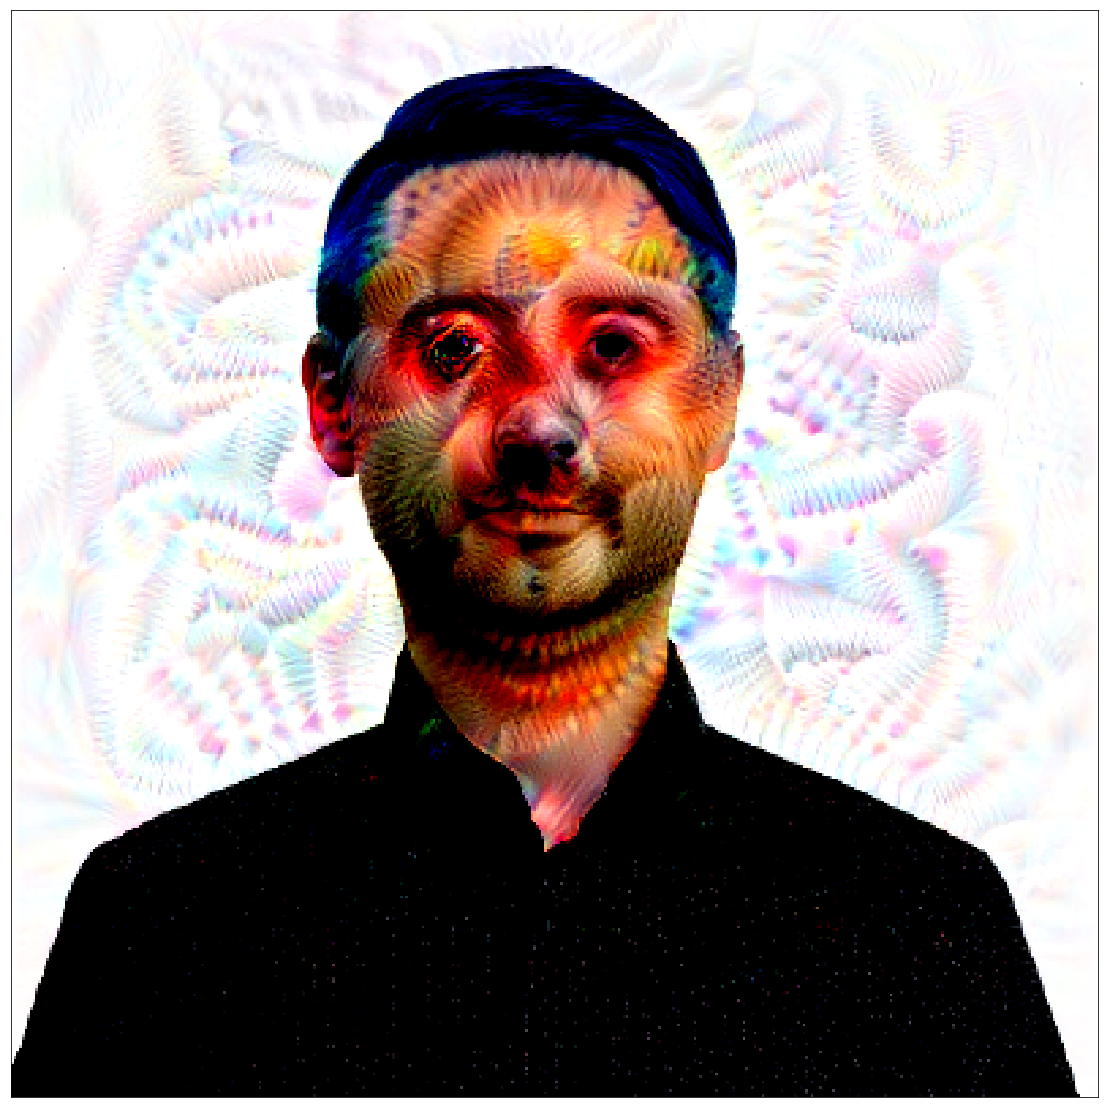

In [22]:
plt.figure( figsize = ( 20, 20 ) )

plt.imshow( img[ 0, :, :, : ] )

plt.xticks( [] )

plt.yticks( [] )

Sweet dreams.<br>
Class dismissed.